# Computational modeling : RL algorithms in a virtual environment

Question : under very low amounts of evidence, how do human sample a complex action space ? Can we infer some form of structure in this exploration ? Can Active Inference provide some answers regarding the mechanistic processes behind it ?



First, we grab the data corresponding to the experiment we're interested in (here, experiment 002). We also remove the subjects that either had technical issues or had very suspicious results. *(we should provide a clear rule on subject exclusion here, maybe based on action variance across all dimensions or reaction times ?).*

In [1]:
# Import the needed packages 
# 
# 1/ the usual suspects
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from jax.tree_util import tree_map
import jax.random as jr


# 2/ Useful functions from our package :
from actynf.jaxtynf.jax_toolbox import _normalize,_jaxlog
from actynf.jaxtynf.jax_toolbox import random_split_like_tree

# To make nice plots : 
from simulate.plot_trajectory import plot_training


# The simulated environment :
from simulate.hmm_weights import behavioural_process # The environment is statically defined by its HMM matrices
from simulate.generate_observations_full_actions import TrainingEnvironment,run_loop,generate_synthetic_data

# The methods to predict actions, compute the log-likelihoods and fit the models :
from simulate.compute_likelihood_full_actions import compute_predicted_actions,compute_loglikelihood
from simulate.compute_likelihood_full_actions import fit_mle_agent,fit_map_agent
from functools import partial


# The artificial agents : 
from agents_no_ck import static_biais_agent


c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NTRIALS = 100
T = 11

# ENVIRONMENTAL CONSTANTS :
N_FEEDBACK_OUTCOMES = 6
TRUE_FEEDBACK_STD = 0.025#0.025
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]

# The weights of the HMM environment
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)

rngkey = jax.random.PRNGKey(np.random.randint(0,10))
ENVIRONMENT = TrainingEnvironment(rngkey,a,b,c,d,e,u,T)

No = N_FEEDBACK_OUTCOMES

# Depending on the dimensions of the problem :
models_constants = {
    "angle" : {
        "N_actions" : 9,
        "N_outcomes" : No,
    },
    "distance" : {
        "N_actions" : 4,
        "N_outcomes" : No,
    },
    "position" : {
        "N_actions" : 9,
        "N_outcomes" : No,
    }
}

Behaviour of one static biais agent with uniform biais :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19
Trial 20
Trial 21
Trial 22
Trial 23
Trial 24
Trial 25
Trial 26
Trial 27
Trial 28
Trial 29
Trial 30
Trial 31
Trial 32
Trial 33
Trial 34
Trial 35
Trial 36
Trial 37
Trial 38
Trial 39
Trial 40
Trial 41
Trial 42
Trial 43
Trial 44
Trial 45
Trial 46
Trial 47
Trial 48
Trial 49
Trial 50
Trial 51
Trial 52
Trial 53
Trial 54
Trial 55
Trial 56
Trial 57
Trial 58
Trial 59
Trial 60
Trial 61
Trial 62
Trial 63
Trial 64
Trial 65
Trial 66
Trial 67
Trial 68
Trial 69
Trial 70
Trial 71
Trial 72
Trial 73
Trial 74
Trial 75
Trial 76
Trial 77
Trial 78
Trial 79
Trial 80
Trial 81
Trial 82
Trial 83
Trial 84
Trial 85
Trial 86
Trial 87
Trial 88
Trial 89
Trial 90
Trial 91
Trial 92
Trial 93
Trial 94
Trial 95
Trial 96
Trial 97
Trial 98
Trial 99


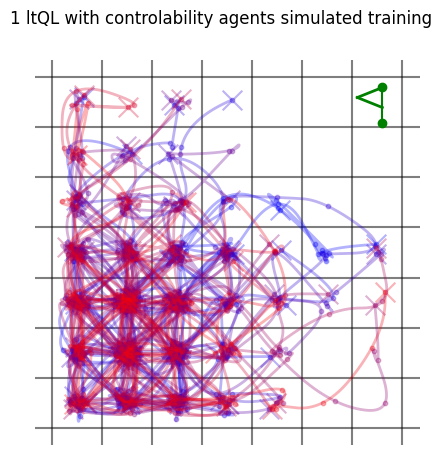

In [3]:

static_biais_agent_hyperparams = {
    "angle":{
        "biais" : _normalize(jnp.ones(9,))[0],
        "beta_biais" : 1.0
    },
    "position":{
        "biais" : _normalize(jnp.ones(9,))[0],
        "beta_biais" : 1.0
    },
    "distance":{
        "biais" : _normalize(jnp.ones(4,))[0],
        "beta_biais" : 1.0
    }
}


SEED = np.random.randint(1000)
params_final,training_hist = run_loop(ENVIRONMENT,static_biais_agent(static_biais_agent_hyperparams,models_constants),SEED,NTRIALS)
simulated_states = np.array(training_hist["env_states"])

fig,ax = plt.subplots(figsize= (5,5))
fig.suptitle("1 ltQL with controlability agents simulated training")
plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)



# controlability_estimates = []
# for trial in range(NTRIALS):
#     (new_qt,new_ck,new_B,new_Bss,new_omega,vect_action_selected,current_stimuli) = training_hist["states"][trial]
#     controlability_estimates.append(list(new_omega.values()))

# for trial in [0,5,-1]:
#     (new_qt,new_ck,new_B,new_Bss,new_omega,vect_action_selected,current_stimuli) = training_hist["states"][trial]
    
#     b = new_B["angle"][-1]
#     Nactions = b.shape[-1]
    
#     # Plot the evolution of transition / action mappings :
#     fig,axs = plt.subplots(2,Nactions+1,figsize=(15,5))
#     fig.suptitle("Learnt transitions (trial {})".format(trial))
    
#     b = new_B["angle"][-1]
#     for k in range(Nactions):
#         ax = axs[0,k]
#         ax.set_title("Action {}".format(k))
#         im = ax.imshow(_normalize(b[...,k])[0])
#     ax = axs[0,k+1]
#     ax.set_title("Spectator angles")
#     bss = new_Bss["angle"][-1]
#     ax.imshow(_normalize(bss)[0])
    
#     b = new_B["position"][-1]
#     for k in range(Nactions):
#         ax = axs[1,k]
#         ax.set_title("Action {}".format(k))
#         im = ax.imshow(_normalize(b[...,k])[0])
#     ax = axs[1,k+1]
#     ax.set_title("Spectator positions")
#     bss = new_Bss["position"][-1]
#     ax.imshow(_normalize(bss)[0])
#     # fig,ax = plt.subplots(1,figsize=(5,5))
#     # fig.suptitle("Learnt Q-table (timestep {})".format(t))
#     # im = ax.imshow(one_training_episode_qtables[t,...],cmap="viridis",vmin=np.min(one_training_episode_qtables),vmax=np.max(one_training_episode_qtables))
#     # ax.set_xlabel("State")
#     # ax.set_xlabel("Action")
#     # fig.colorbar(im)

# flat_contr_est = np.swapaxes(np.array(controlability_estimates),1,2)
# Nmod = flat_contr_est.shape[-1]
# flat_contr_est = np.reshape(flat_contr_est,(-1,Nmod))
# fig,ax=plt.subplots(figsize=(10,4))
# fig.suptitle("$\Omega$ (Actor v. Spectator arbritrator) evolution for all action modalities")
# for mod in range(Nmod):
#     ax.plot(flat_contr_est[...,mod],label=list(new_omega.keys())[mod])
# ax.set_xlabel("Timestep")
# ax.set_ylabel("Controlability arbitrator $\Omega$")
# ax.grid()
# ax.legend()

Example of behaviour simulated by a given model in the environment :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


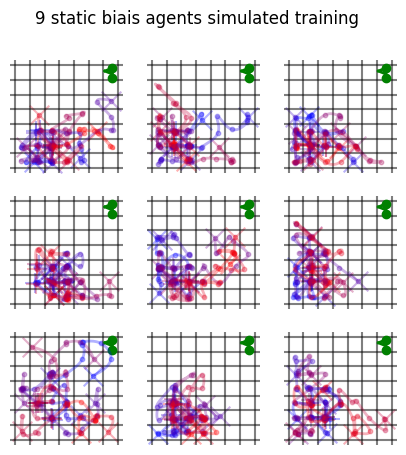

In [4]:
# We can encode static biases for a specific action modality using this model. The global temperature parameter
# beta indicates how likley the agent is to shift focus !

NTRIALS = 10
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("9 static biais agents simulated training")

static_biais_agent_hyperparams = {
    "angle":{
        "biais" : _normalize(jnp.array([0.0,0.1,0.2,0.1,0.5,0.1,0.0,0.0,0.0]))[0],
        "beta_biais" : 10.0
    },
    "position":{
        "biais" : _normalize(jnp.ones(9,))[0],
        "beta_biais" : 10.0
    },
    "distance":{
        "biais" : _normalize(jnp.ones(4,))[0],
        "beta_biais" : 1.0
    }
}

for ax in axs.reshape(-1): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)

    params_final,training_hist = run_loop(ENVIRONMENT,static_biais_agent(static_biais_agent_hyperparams,models_constants),SEED,NTRIALS)

    simulated_states = np.array(training_hist["env_states"])

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)


Generate some synthetic data for the model we're interested in :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19
GT LL : 
{'angle': Array(-437.69586, dtype=float32), 'distance': Array(-277.2587, dtype=float32), 'position': Array(-439.44504, dtype=float32)}


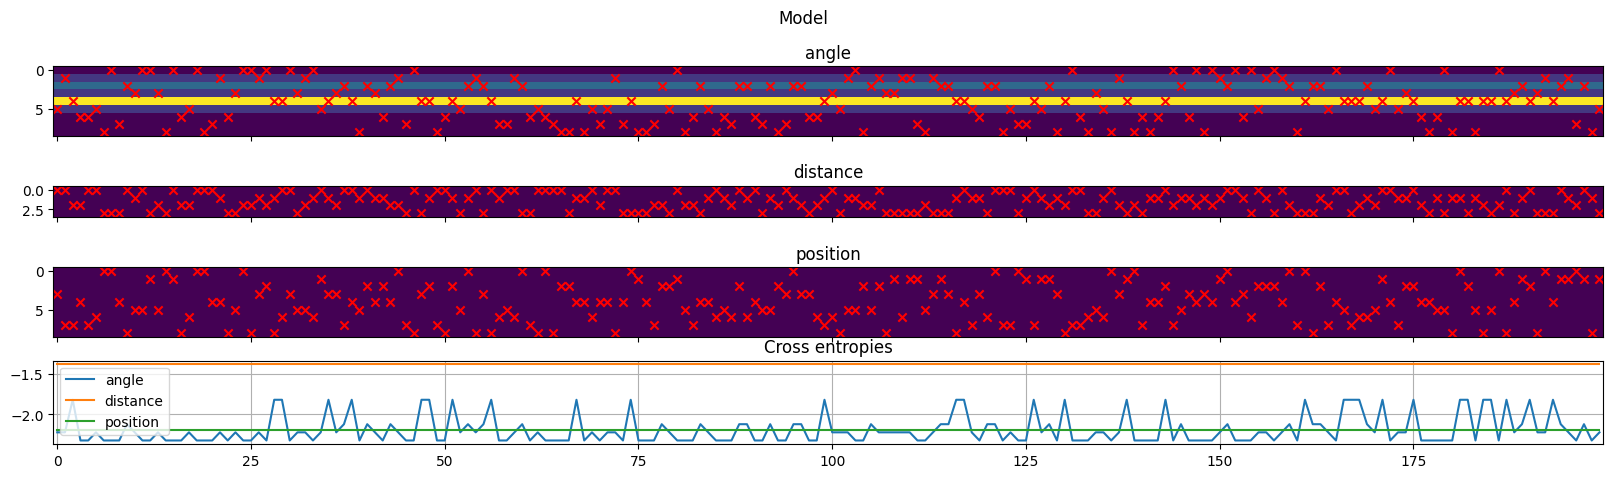

In [8]:

static_biais_agent_hyperparams = {
    "angle":{
        "biais" : _normalize(jnp.array([0.0,0.1,0.2,0.1,0.5,0.1,0.0,0.0,0.0]))[0],
        "beta_biais" : 3.0
    },
    "position":{
        "biais" : _normalize(jnp.ones(9,))[0],
        "beta_biais" : 10.0
    },
    "distance":{
        "biais" : _normalize(jnp.ones(4,))[0],
        "beta_biais" : 1.0
    }
}

n_trials = 20
SYNTHETIC_DATA = generate_synthetic_data(ENVIRONMENT,static_biais_agent(static_biais_agent_hyperparams,models_constants),
                                         n_trials=n_trials,seed = 1,verbose = True)
(formatted_stimuli,bool_stimuli,rewards,true_actions,tmtsp) = SYNTHETIC_DATA


# Optimal likelihood for the data (the best predictive power we should be able to achieve ):
lls,ces = compute_loglikelihood(SYNTHETIC_DATA,static_biais_agent(static_biais_agent_hyperparams,models_constants),"sum")
final_parameters,predicted_actions,state_history = compute_predicted_actions(SYNTHETIC_DATA,static_biais_agent(static_biais_agent_hyperparams,models_constants))
model_states,other_data = state_history

# plt.imshow(np.reshape(ck_history["position"],(-1,9)))
fig,axs = plt.subplots(len(true_actions)+1,1,figsize=(n_trials,5),sharex=True)
fig.suptitle("Model")

for i,key in enumerate(predicted_actions.keys()):
    ax = axs[i]

    N_action_cat = true_actions[key].shape[-1]
    
    prediction_map = np.reshape(predicted_actions[key],(-1,N_action_cat))
    ax.set_title(key)    
    ax.imshow(prediction_map.T)
        
    N_timesteps  = prediction_map.shape[0]
    ax.scatter(np.arange(N_timesteps),np.argmax(true_actions[key],axis=-1),color="red",marker="x")

ax = axs[-1]
ax.set_title("Cross entropies")
for mod,series in ces.items():
    ax.plot(series.flatten(),label=mod)
ax.legend()
ax.grid()

print("GT LL : ")
print(lls)

step 0, loss: Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([1194.7002, 1183.8472, 1182.3883, 1188.7151, 1213.5022, 1186.3517,
       1199.9099, 1190.6528, 1185.781 , 1195.9191, 1202.9813, 1185.6143,
       1178.3452, 1184.3768, 1192.4563, 1193.7427, 1178.2297, 1185.269 ,
       1193.762 , 1196.3378, 1182.8351, 1181.5663, 1188.7142, 1199.5298,
       1197.6843, 1185.1038, 1186.6383, 1201.8132, 1180.2677, 1177.3185,
       1192.6426, 1183.546 , 1200.712 , 1176.8903, 1195.5865, 1181.0249,
       1170.7758, 1194.7999, 1180.4438, 1187.1282, 1193.7107, 1183.2312,
       1204.2822, 1171.8412, 1195.9419, 1191.7664, 1188.4612, 1191.8876,
       1173.6005, 1212.0317, 1205.6772, 1188.9113, 1179.6486, 1184.568 ,
       1196.2018, 1171.0718, 1189.0388, 1188.3578, 1168.1278, 1201.9893,
       1174.0139, 1178.6074, 1175.9908, 1190.9048, 1206.5093, 1175.7307,
       1181.031 , 1191.959 , 1197.2815, 1170.7283, 1176.8035, 1184.5464,
       1181.9   , 1193.6848, 1182.0944,

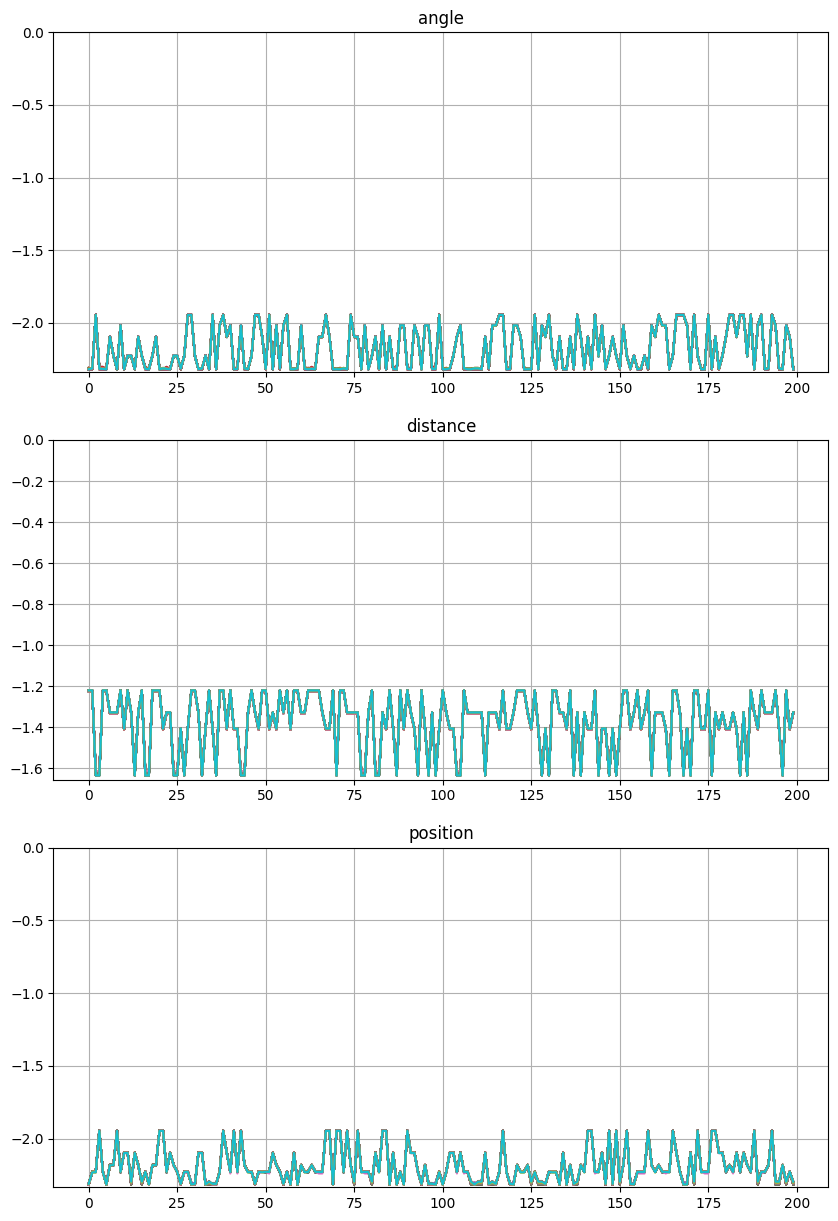

In [9]:
from simulate.compute_likelihood_full_actions import _uniform_sample_leaf
from actynf.jaxtynf.jax_toolbox import random_split_like_tree

# Assuming uniform distributions for all parameters :
feature_range_tree ={
    "angle":{
        "biais" : jnp.array([-10,10,9]),
        "beta_biais" : jnp.array([-10,10])
    },
    "position":{
        "biais" : jnp.array([-10,10,9]),
        "beta_biais" : jnp.array([-10,10])
    },
    "distance":{
        "biais" : jnp.array([-10,10,4]),
        "beta_biais" : jnp.array([-10,10])
    }
}

# n_heads = 10

# # Grab a few initial starting positions
# rng_key_tree = random_split_like_tree(rngkey,feature_range_tree)
# sampler = partial(_uniform_sample_leaf,size=n_heads)
# initial_feature_vectors = tree_map(sampler,rng_key_tree,feature_range_tree)

# print(initial_feature_vectors["angle"]["biais"].shape)

static_agent = partial(static_biais_agent,constants= models_constants)

all_fin_params,(gt_mle,all_losses,all_param_histories),encoding_function = fit_mle_agent(SYNTHETIC_DATA,
                            static_agent,feature_range_tree,jax.random.PRNGKey(0),
                            n_heads=100,num_steps=250,verbose=True)
final_lls,cross_entropies = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,static_agent(encoding_function(x)),"sum"))(all_fin_params)

print(cross_entropies["angle"])
print(min(final_lls["angle"]))
print(max(final_lls["angle"]))
fig,axs = plt.subplots(3,1,figsize=(10,15))
for i,key in enumerate(cross_entropies.keys()):
    axs[i].set_title(key)
    for head in range(100):
        axs[i].plot(cross_entropies[key][head].flatten())
    axs[i].set_ylim(ymax=0.0)
    axs[i].grid()
plt.show()

Given the best match for subject parameters, we then reconstruct the evolution of model states / parameters across trials.

None
(100, 9)


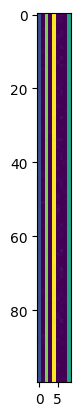

In [7]:

ll_term,predictions,model_variables  = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,static_agent(encoding_function(x)),"sum",True))(all_fin_params)
model_states,other_data = model_variables


# The states of this model are None, so it's not very useful :p
print(model_states)

# But let's look at the predicted biaises for all optimization heads :
biaises = jax.vmap(lambda x : encoding_function(x))(all_fin_params)
print(biaises["angle"]["biais"].shape)

plt.imshow(biaises["angle"]["biais"])


The conclusions of the experts point towards different kinds of explanations regarding the observed data ! However, most of them seem to match the input parameters ! :D